# Comparison of chronograms obtained with the correct Epoch model or with a homogeneous model with the true simulated tree

## Analysis of the link function between O2 partial pressure and probability of being an aerobe
We use a logistic function (https://en.wikipedia.org/wiki/Logistic_function).
f(x) = L/(1+exp(-k*(x-x0)))
We have : L: the maximum value, i.e. 1.0
k: the steepness of the curve
x0: the sigmoid's midpoint


In [1]:
import sys
from ete3 import Tree, TreeStyle, NodeStyle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import math
import scipy.stats
import re
import arviz as az


In [2]:

x = np.linspace(0, 100, 500)

def logistic(L, k, x0, x):
    return L/(1+np.exp(-k*(x-x0)))

Text(0, 0.5, 'Probability of being aerobe')

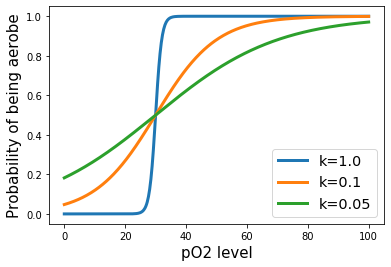

In [3]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()
L = 1.0
k = 1.0
x0 = 30
ax.plot(x, logistic(L, k, x0, x), linewidth=3, label='k=1.0')
k=0.1
ax.plot(x, logistic(L, k, x0, x), linewidth=3, label='k=0.1')
k=0.05
ax.plot(x, logistic(L, k, x0, x), linewidth=3, label='k=0.05')
legend = ax.legend(loc='lower right', shadow=False, fontsize='x-large')
ax.set_xlabel("pO2 level", fontsize=15)
ax.set_ylabel("Probability of being aerobe", fontsize=15)



We choose to simulate data with k=0.1, x0=30 (orange curve above).

## Comparison of simulated and inferred chronograms
First, let's open the chronograms.

In [4]:

def readMAPChronogramFromRBOutput (file):
    try:
        f=open(file, 'r')
    except IOError:
        print ("Unknown file: "+file)
        sys.exit()
    line = ""
    treeStrings = list()
    for l in f:
        if "tree TREE1 = [&R]" in l:
            line = l.replace("tree TREE1 = [&R]", "")
            tree = re.sub('\[&index=\d+([,\w=\d,%\.\{\}])*\]', "", line)#[&index=102,posterior=1.000000,ccp=1.000000,height_95%_HPD={0.025722,0.071446}]
            #print(tree)
            return Tree(tree)


t_true = readMAPChronogramFromRBOutput("TestData/simulated_Tree.nex")
t_epo = readMAPChronogramFromRBOutput("output/correct_model_map.tre")
t_homo = readMAPChronogramFromRBOutput("output/homogeneous_model_map.tre")






## Let's plot the trees

In [5]:
# Plot a tree
ts = TreeStyle()
ts.min_leaf_separation= 0
ts.branch_vertical_margin = 1 # 10 pixels between adjacent branches
ts.scale = 200
ts.show_leaf_name = False
nstyle = NodeStyle()
nstyle["size"] = 0


### True tree

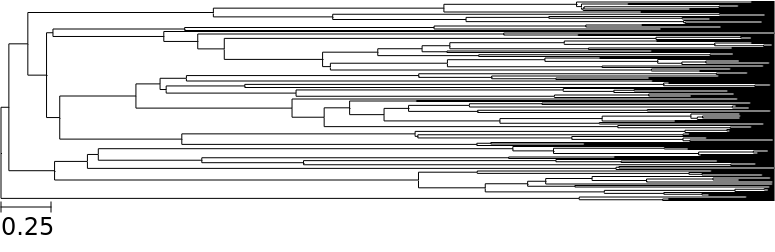

In [6]:
for n in t_true.traverse():
    n.set_style(nstyle)
t_true.render("%%inline", tree_style=ts)


### Epoch tree

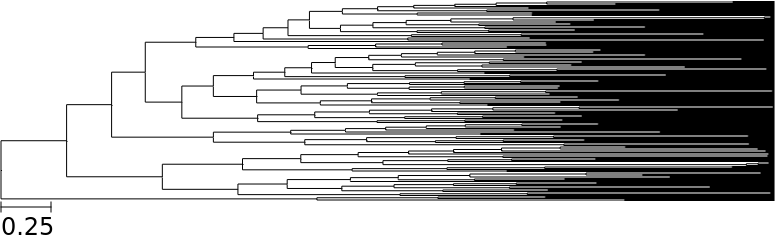

In [7]:
for n in t_epo.traverse():
    n.set_style(nstyle)
t_epo.render("%%inline", tree_style=ts)

### Homogeneous tree

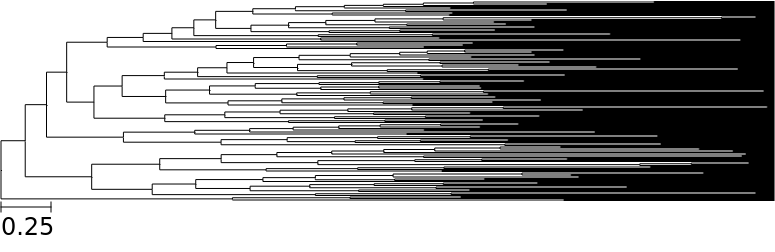

In [8]:
for n in t_homo.traverse():
    n.set_style(nstyle)
t_homo.render("%%inline", tree_style=ts)

### All trees have been read, let's get their node heights, and compare them.

In [9]:
def getNodeHeights( t ):
    node2Height = dict()
    id2Height = dict()
    for node in t.traverse("postorder"):
        if node not in node2Height:
            node2Height[node] = 0.0
            id2Height[node.name] = 0.0
        if node.up:
            if node.up.name =='':
                leaves = node.up.get_leaves()
                name=""
                for l in leaves:
                    name += l.name
                node.up.name=name
            node2Height[node.up] = node2Height[node] + node.dist
            id2Height[str(node.up.name)] = node2Height[node] + node.dist
      # print node.name + " : " + str(node2Height[node])
    #return node2Height,id2Height
    return id2Height


heights_true = list(getNodeHeights(t_true).values())
heights_epo = list(getNodeHeights(t_epo).values())
heights_homo = list(getNodeHeights(t_homo).values())


Lineage through time plot for the simulated tree:

In [10]:
def cumulativeNumberOfLineages(heights):
    heights.sort(reverse=True)
    counts=list()
    num=0
    last_height = -1
    levels = list()
    for height in heights:
        num = num + 1
        if (last_height != height):
            counts.append(num)
            levels.append(height)
            last_height = height
        else:
            pass
    return ( levels, counts)
    
levels, counts = cumulativeNumberOfLineages(heights_true.copy())


Text(0, 0.5, 'Number of nodes so far')

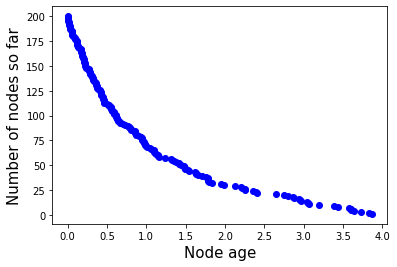

In [11]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca()
ax.plot(levels, counts, 'bo')
ax.set_xlabel("Node age", fontsize=15)
ax.set_ylabel("Number of nodes so far", fontsize=15)

In [12]:
def plotAndComputeCorrelation(x,y,namex, namey, logyn, logxn, limx=None, limy=None):
    print("Pearson correlation coefficient and p-value: "+ str(scipy.stats.pearsonr(x, y)))
    #Plotting:
    fig = plt.figure()
    ax = fig.gca()
    ax.plot([0.0, 4.0], [0.0, 4.0], linestyle='--', lw=2, color="grey")
    ax.plot(x, y, 'bo')
    ax.set_xlabel(namex, fontsize=15)
    ax.set_ylabel(namey, fontsize=15)
#plt.legend(['data'], loc='upper left')
    if logyn:
        ax.yscale('log')
    if logxn:
        ax.xscale('log')
    if not limx == None:
        ax.xlim(limx)
    if not limy == None:
        ax.ylim(limy)
    #plt.grid()
    

Pearson correlation coefficient and p-value: (0.5306194056964679, 2.3368682899598602e-30)


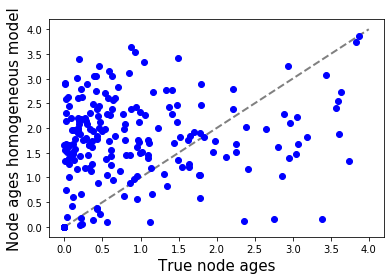

In [13]:
%matplotlib inline

plotAndComputeCorrelation(heights_true,heights_homo,'True node ages', 'Node ages homogeneous model', False, False)

Pearson correlation coefficient and p-value: (0.5168842492181354, 1.2279030573543149e-28)


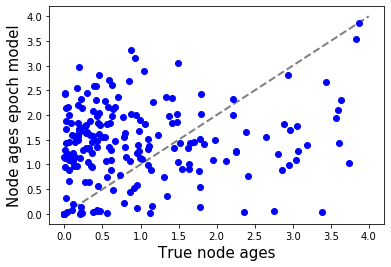

In [14]:
%matplotlib inline

plotAndComputeCorrelation(heights_true,heights_epo,'True node ages', 'Node ages epoch model', False, False)

Pearson correlation coefficient and p-value: (0.9943065351097056, 0.0)


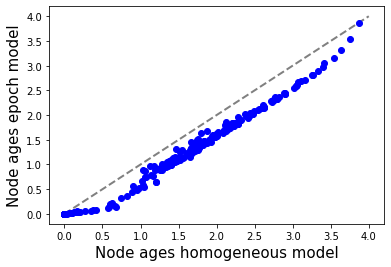

In [15]:
%matplotlib inline

plotAndComputeCorrelation(heights_homo,heights_epo,'Node ages homogeneous model', 'Node ages epoch model', False, False)

## Let's look at the traces

In [16]:
d_homo = pd.read_csv("output/homogeneous_model.log", header=0, delimiter="\t")
d_epo = pd.read_csv("output/correct_model.log", header=0, delimiter="\t")

In [17]:
d_homo.describe()

,Iteration,Replicate_ID,Posterior,Likelihood,Prior,birth,branchRates,death,pi_aerobe,pi_aerobe_root,pi_anaerobe,pi_anaerobe_root,root_age,root_frequency[1],root_frequency[2]
count,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4.002000e+03,4002.000000,4002.000000
mean,2000.500000,0.500000,-7057.925929,-6060.980350,-996.945585,2.080303,0.005632,0.065018,0.946299,0.960834,0.053701,0.039166,3.867742e+00,0.960834,0.039166
std,1155.422217,0.500062,111.110593,91.875649,26.361987,0.185691,0.001635,0.064686,0.191092,0.103232,0.191092,0.103232,2.487210e-13,0.103232,0.103232
min,0.000000,0.000000,-13101.910000,-11199.390000,-2087.464000,0.055721,0.000208,0.000040,0.122772,0.032307,0.001698,0.000012,3.867742e+00,0.032307,0.000012
25%,1000.250000,0.000000,-7061.395250,-6058.795250,-1005.287500,1.974634,0.005364,0.019166,0.997675,0.978498,0.002162,0.001918,3.867742e+00,0.978498,0.001918
50%,2000.500000,0.500000,-7053.051500,-6053.202000,-998.256450,2.083973,0.005922,0.045337,0.997754,0.993363,0.002246,0.006637,3.867742e+00,0.993362,0.006637
75%,3000.750000,1.000000,-7045.315500,-6048.690250,-990.167200,2.189522,0.006462,0.089461,0.997838,0.998082,0.002325,0.021502,3.867742e+00,0.998082,0.021502
max,4001.000000,1.000000,-7004.761000,-6032.687000,-899.312200,3.628332,0.028877,0.560596,0.998302,0.999988,0.877228,0.967693,3.867742e+00,0.999988,0.967693


In [18]:
d_epo.describe()

,Iteration,Replicate_ID,Posterior,Likelihood,Prior,birth,branchRates,death,k,pi_aerobe[1],...,pi_aerobe_root,pi_anaerobe[1],pi_anaerobe[2],pi_anaerobe[3],pi_anaerobe[4],pi_anaerobe_root,root_age,root_frequency[1],root_frequency[2],x0
count,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4002.000000,4.002000e+03,...,4.002000e+03,4002.0,4002.0,4002.000000,4.002000e+03,4002.0,4.002000e+03,4.002000e+03,4002.0,4002.000000
mean,2000.500000,0.500000,-7074.873994,-6065.973482,-1008.900510,2.494739,0.008202,0.093360,0.405775,8.175562e-10,...,8.175563e-10,1.0,1.0,0.999999,3.831945e-04,1.0,3.867742e+00,8.175562e-10,1.0,78.849844
std,1155.422217,0.500062,442.580036,424.125159,29.389304,0.263620,0.006188,0.094983,0.104323,2.441410e-09,...,2.441410e-09,0.0,0.0,0.000002,2.633719e-04,0.0,2.487210e-13,2.441410e-09,0.0,5.470046
min,0.000000,0.000000,-34986.340000,-32871.810000,-2114.528000,0.048863,0.001248,0.000014,0.259510,6.292330e-23,...,6.292335e-23,1.0,1.0,0.999983,2.220450e-16,1.0,3.867742e+00,6.292330e-23,1.0,58.759940
25%,1000.250000,0.000000,-7079.908750,-6064.504250,-1019.716250,2.316468,0.004435,0.027144,0.293645,4.035008e-19,...,4.035005e-19,1.0,1.0,0.999999,2.148935e-04,1.0,3.867742e+00,4.035008e-19,1.0,73.360390
50%,2000.500000,0.500000,-7068.354000,-6058.666500,-1009.189000,2.473810,0.006529,0.064802,0.417995,1.131075e-15,...,1.131078e-15,1.0,1.0,1.000000,3.140065e-04,1.0,3.867742e+00,1.131075e-15,1.0,81.899495
75%,3000.750000,1.000000,-7055.442000,-6053.200250,-997.503525,2.653554,0.009106,0.128490,0.510688,4.933092e-10,...,4.933092e-10,1.0,1.0,1.000000,4.319660e-04,1.0,3.867742e+00,4.933092e-10,1.0,83.492865
max,4001.000000,1.000000,-6999.661000,-6034.946000,-953.175300,3.622784,0.087340,0.809065,0.871466,2.207910e-08,...,2.207913e-08,1.0,1.0,1.000000,1.654130e-03,1.0,3.867742e+00,2.207910e-08,1.0,85.441690


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce12984668>],
      dtype=object)

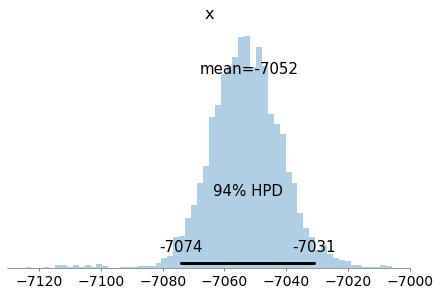

In [19]:
az.plot_posterior(np.array(d_homo['Posterior'][500:], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce121326a0>],
      dtype=object)

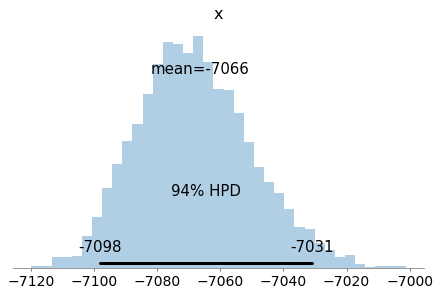

In [20]:
az.plot_posterior(np.array(d_epo['Posterior'][500:], dtype=pd.Series))

The epoch model has a better posterior, but it seems like the two chains may not have converged to the same place.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce120e8978>],
      dtype=object)

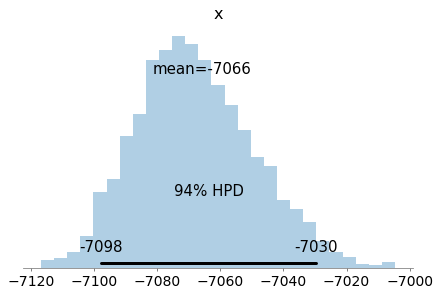

In [21]:
az.plot_posterior(np.array(d_epo['Posterior'][500:][d_epo['Replicate_ID']==0], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce12041c88>],
      dtype=object)

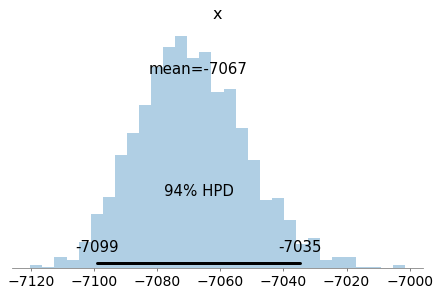

In [22]:
az.plot_posterior(np.array(d_epo['Posterior'][500:][d_epo['Replicate_ID']==1], dtype=pd.Series))

## Do we estimate the rate of evolution correctly? We simulated with value 0.02.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce11ffdfd0>],
      dtype=object)

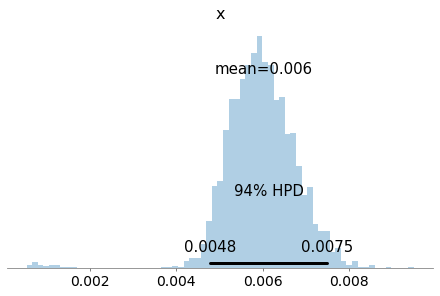

In [23]:
az.plot_posterior(np.array(d_homo['branchRates'][500:], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce11edd208>],
      dtype=object)

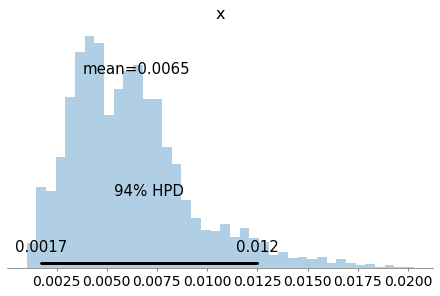

In [24]:
az.plot_posterior(np.array(d_epo['branchRates'][500:], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce11f0de80>],
      dtype=object)

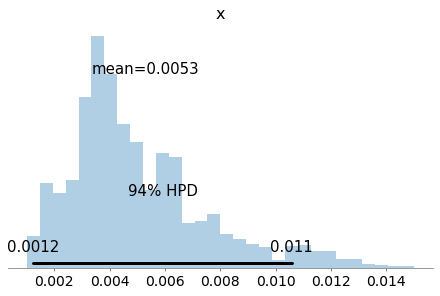

In [25]:
az.plot_posterior(np.array(d_epo['branchRates'][500:][d_epo['Replicate_ID']==0], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce11dda898>],
      dtype=object)

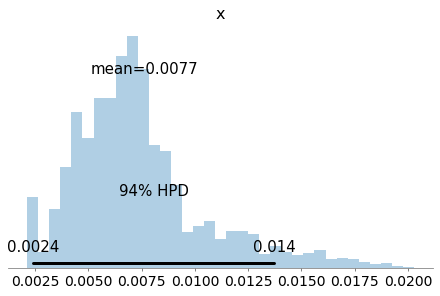

In [26]:
az.plot_posterior(np.array(d_epo['branchRates'][500:][d_epo['Replicate_ID']==1], dtype=pd.Series))

## Let's look at the probability of oxygen at the root (true value: 0.04787969)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce11d74a58>],
      dtype=object)

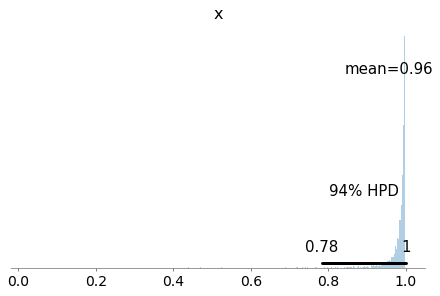

In [27]:
az.plot_posterior(np.array(d_homo['pi_aerobe_root'][500:], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce11d5b080>],
      dtype=object)

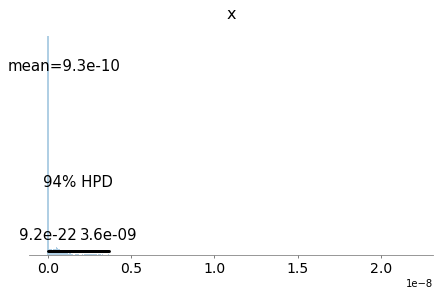

In [28]:
az.plot_posterior(np.array(d_epo['pi_aerobe_root'][500:], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce119b4630>],
      dtype=object)

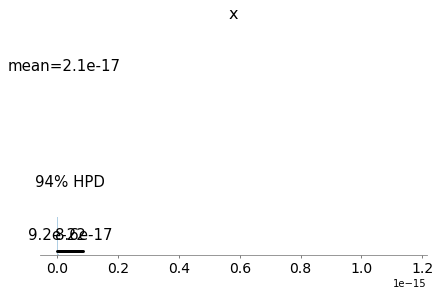

In [29]:
az.plot_posterior(np.array(d_epo['pi_aerobe_root'][500:][d_epo['Replicate_ID']==0], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce09c83e48>],
      dtype=object)

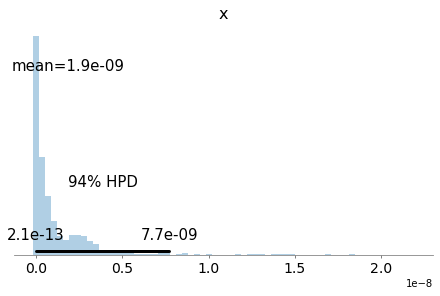

In [30]:
az.plot_posterior(np.array(d_epo['pi_aerobe_root'][500:][d_epo['Replicate_ID']==1], dtype=pd.Series))

## Checking the parameters of the link function between pO2 and p_arobe.
k and x0 are the two parameters, with true values 0.1 and 30, respectively.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce1134cb38>],
      dtype=object)

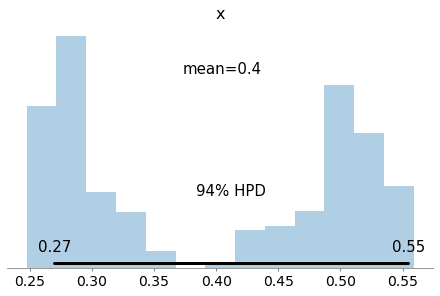

In [31]:
az.plot_posterior(np.array(d_epo['k'][500:], dtype=pd.Series))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce09944080>],
      dtype=object)

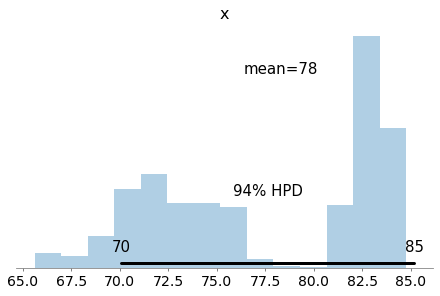

In [32]:
az.plot_posterior(np.array(d_epo['x0'][500:], dtype=pd.Series))

The two parameters are not well estimated, and their posterior distribution seems to be bimodal, suggesting the two chains may not have converged to the same area. 